## Imports

In [20]:

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import cv2

from numpy import genfromtxt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, mean_absolute_error, balanced_accuracy_score
from sklearn import metrics
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.preprocessing import normalize
import graphviz 
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import SVG

from IPython.display import Image  

#----------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
#set image size
num_pixels = 24


In [2]:
# Importing training  data from CSV files
x_train_import = genfromtxt('x_train_gr_smpl.csv', delimiter=',', skip_header =1)
y_train_import = genfromtxt('y_train_smpl.csv', delimiter=',', skip_header =1 )

In [3]:
# Importing testing data from CSV files
x_test_import = genfromtxt('x_test_gr_smpl.csv', delimiter=',', skip_header =1)
y_test_import = genfromtxt('y_test_smpl.csv', delimiter=',', skip_header =1 )


In [4]:
# Normalisation of pixels
# x_train_import = x_train_import.astype('float')/255
# x_test_import  = x_test_import.astype('float')/255


In [5]:
# Check data has been imported correctly 
print(x_train_import.shape)
print(y_train_import.shape)
print(x_test_import.shape)
print(y_test_import.shape)

(12660, 2304)
(12660,)
(4170, 2304)
(4170,)


## Preprocessing

In [6]:
# Combinging data with labels

y_train_import = y_train_import.reshape(12660,1)
train_data_combined = np.append(x_train_import, y_train_import, axis=1)

y_test_import = y_test_import.reshape(4170,1)
test_data_combined = np.append(x_test_import, y_test_import, axis=1)


In [7]:
# Randomises row order in a reproducable way 
np.random.seed(0)
np.random.shuffle(train_data_combined)
np.random.shuffle(test_data_combined)

In [29]:
#equalize the data so all classes have the same amount of instances (240)

def equilize(data):
    train_combined_equal = []
    for x in range(10):
        count = 0
        #while count < 2000:
        for i in data :
            if i[-1] == x and count < 4000:
                train_combined_equal.append(i)
                count += 1
        
    train_combined_equal = np.asarray(train_combined_equal)
    np.random.shuffle(train_combined_equal)      
    
    return train_combined_equal

train_combined_equal = equilize(train_data_combined)
print("length:",len(train_combined_equal))

length: 12660


In [30]:
# Split data and lables that have undergone the same randomization process
# x_train = train_combined_equal[:,:-1]
# y_train = train_combined_equal[:, [-1]].reshape(2400,)   
x_train = train_combined_equal[:,:-1]
y_train = train_combined_equal[:, [-1]].reshape(len(train_combined_equal),)   


x_train_all = train_data_combined[:,:-1]
y_train_all = train_data_combined[:, [-1]].reshape(12660,)

x_test = test_data_combined[:,:-1]
y_test = test_data_combined[:, [-1]].reshape(4170,)

#what is the mean of the data
print("train mean:",np.mean(x_train))
print("test mean:",np.mean(x_test))
#shows that test set has been ofset

train mean: 80.957739030685
test mean: 85.48841426858513


In [31]:
#  Reducing the number of attributes using opencv's reduce functionality as shown in the second python Lecture
#  As seen in python lectures: https://vision.hw.ac.uk/webapps/blackboard/content/listContent.jsp?course_id=_94419_1&content_id=_3391865_1
x_train_all = np.apply_along_axis(
        func1d=lambda img: cv2.resize(img.reshape((48,48)), (num_pixels,num_pixels)),
        axis =1, arr = x_train_all).reshape((-1,num_pixels*num_pixels))

x_train = np.apply_along_axis(
        func1d=lambda img: cv2.resize(img.reshape((48,48)), (num_pixels,num_pixels)),
        axis =1, arr = x_train).reshape((-1,num_pixels*num_pixels))

x_test  = np.apply_along_axis(
        func1d=lambda img: cv2.resize(img.reshape((48,48)), (num_pixels,num_pixels)),
        axis =1, arr = x_test).reshape((-1,num_pixels*num_pixels))

In [32]:
x_train_test = np.append(x_train,x_test, axis=0)
y_train_test = np.append(y_train,y_test, axis=0)

## Test Kappa score vs MAE

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.342891 to fit


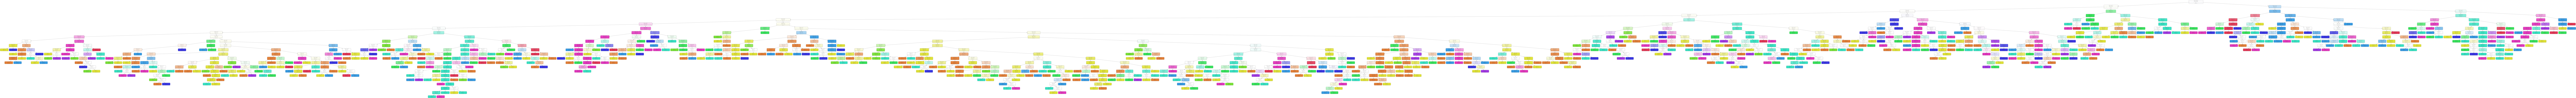

In [33]:
#try standared tree with no limmits 
clf = tree.DecisionTreeClassifier()
#clf.fit(x_train, y_train)
clf.fit(x_train, y_train)
graph = graphviz.Source(tree.export_graphviz(clf, out_file=None,filled=True,rounded=True,class_names=True))  
png_bytes = graph.pipe(format='png')  
name = "overfitting_base_tree.png"
with open(name,'wb') as f:
    f.write(png_bytes)

Image(name)



In [34]:
# graph = graphviz.Source(dot_data) 
# graph.render("overfitting_tree") 
#predict on test set
y_pred_test_data = clf.predict(x_test)
print(classification_report(y_test, y_pred_test_data))

              precision    recall  f1-score   support

         0.0       0.67      0.68      0.68       450
         1.0       0.67      0.74      0.71       630
         2.0       0.78      0.53      0.63       150
         3.0       0.86      0.82      0.84       420
         4.0       0.78      0.80      0.79       690
         5.0       0.89      0.95      0.92       720
         6.0       0.80      0.81      0.81       270
         7.0       0.28      0.23      0.25        60
         8.0       0.91      0.86      0.88       690
         9.0       0.53      0.33      0.41        90

    accuracy                           0.79      4170
   macro avg       0.72      0.68      0.69      4170
weighted avg       0.79      0.79      0.79      4170



In [36]:
print("kappa:",cohen_kappa_score(y_test, y_pred_test_data))
print("MAE:",mean_absolute_error(y_test, y_pred_test_data))# kappa greater then good

kappa: 0.7556584640210782
MAE: 0.6410071942446043
